# Flower Recognition

In the final exam of ML 100 marathon, I have to determine the species of the flowers. There are 5 different flowers we have to point out: daisy, dandelion, rose, sunflower, tulip. I will elaborate the process for using CNN model to tackle this kind of question. So here we go.

## Feature Extraction

For pictures of flowers, It's not strange if we rotate them even reverse them. This may help the model to deal with different shape of flowers it can be. We can tweak a little bit about these training data by the following process.

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
from IPython.display import display 
from PIL import Image
%matplotlib inline

Using TensorFlow backend.


In [2]:
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                      samplewise_center = True, 
                                                                      samplewise_std_normalization = True)

In [3]:
def get_data(batch_size = 32, target_size= (128, 128)):
    '''
    Import data from directory.
    '''
    train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale= 1./255, 
                                                             shear_range= 0.2, 
                                                             zoom_range=0.2, 
                                                             rotation_range = 0.2,
                                                             horizontal_flip=True,
                                                             vertical_flip=True,
                                                             fill_mode = 'nearest',
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             samplewise_center = True, 
                                                             samplewise_std_normalization = True)
    validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                      samplewise_center = True, 
                                                                      samplewise_std_normalization = True)
    train = train_datagen.flow_from_directory(r'./image_data/train', 
                                  target_size = target_size,
                                  batch_size = batch_size)
    validation = train_datagen.flow_from_directory(r'./image_data/validation', 
                                  target_size = target_size,
                                  batch_size = batch_size)
    return train, validation

## Buiding the model

We can see that the dataset only contains 2,823 pitures. That is not enough to train a CNN model. There is a way to increase accuracy with small dataset. It called Transfer learning. In this problem, we'll use the ResNet50 model to embed into our CNN model.

In [4]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Activation, Input, Dropout
from keras.regularizers import l1_l2, l2
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras import layers

In [5]:
def build_model(train, num_filters=32, num_conv_layer=3, num_layer_node = [256, 128, 64, 32], transfer = None,
                num_transfer_freeze = 0):
    
    # adding transfer learning model
    if transfer:
        inputs = transfer.inputs
        x = transfer.outputs[0]
        
    else:
        # CNN model
#         for i in range(num_conv_layer):
#             if i == 0:
#                 # First Convolution Layer
#                 inputs = Input(shape=train.image_shape, name = 'Input_layer')
#                 x = Conv2D(filters = num_filters*2**(i), kernel_size=(3,3), name = 'Conv_Pad_' + str(i))(inputs)
#                 x = Activation('relu', name = 'Con_relu_'+str(i))(x)
#                 x = MaxPool2D(name = 'MaxPool_' + str(i), pool_size=(2,2), padding='valid')(x)                
#                 x = Dropout(0.1*(i+1))(x)
#             else:
#                 # Other Convolution Layers
#                 x = Conv2D(filters = num_filters*2**(i), kernel_size=(2,2), name = 'Conv_Pad_' + str(i))(x)
#                 x = Activation('relu', name = 'Con_relu_'+str(i))(x)
#                 x = MaxPool2D(name = 'MaxPool_' + str(i), pool_size=(2,2), padding='valid')(x)
#                 x = BatchNormalization()(x)
#                 x = Dropout(0.1*(i+1))(x)
        inputs = Input(shape=train.image_shape, name = 'Input_layer')
        x = Conv2D(filters = num_filters, kernel_size=(3,3), name = 'Conv_Pad_' + str(1), padding = 'same')(inputs)
        x = Conv2D(filters = num_filters, kernel_size=(3,3), name = 'Conv_Pad_' + str(2), padding = 'same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPool2D(name = 'MaxPool_' + str(1), pool_size=(2,2))(x)
        
        x = Conv2D(filters = num_filters*2, kernel_size=(3,3), name = 'Conv' + str(1), padding = 'same')(x)
        x = Conv2D(filters = num_filters*2, kernel_size=(3,3), name = 'Conv_Pad_' + str(3), padding = 'same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPool2D(name = 'MaxPool_' + str(2), pool_size=(2,2))(x)
#         x = Dropout(0.1)(x)
        
        x = Conv2D(filters = num_filters*4, kernel_size=(3,3), name = 'Conv' + str(2), padding = 'same')(x)
        x = Conv2D(filters = num_filters*4, kernel_size=(3,3), name = 'Conv_Pad_' + str(4), padding = 'same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPool2D(name = 'MaxPool_' + str(3), pool_size=(2,2))(x)
        x = Dropout(0.1)(x)
        
        x = Conv2D(filters = num_filters*8, kernel_size=(3,3), name = 'Conv' + str(3), padding = 'same')(x)
        x = Conv2D(filters = num_filters*8, kernel_size=(3,3), name = 'Conv_Pad_' + str(5), padding = 'same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPool2D(name = 'MaxPool_' + str(4), pool_size=(2,2))(x)
        x = Dropout(0.1)(x)
    
    # Flatten data
    x = Flatten()(x)
    
    # Full connection layers
    for i, n in enumerate(num_layer_node):
        # Dense layers with batch normalization
        x = Dense(n, name = 'Layer_'+str(i), kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Activation('relu', name = 'ReLU_'+str(i))(x)
        x = Dropout(0.5+0.1*i)(x)
#         x = Dropout(0.55)(x)
    
    # Ouput layer
    output = Dense(train.num_classes, activation = 'softmax', name = 'Output_layer', kernel_regularizer=l2(0.01))(x)
    
    model = Model(inputs = inputs, outputs = output)
    
    # fix transfer learning parameters
    if num_transfer_freeze:
        for i, layer in enumerate(model.layers):
            if i >= num_transfer_freeze:
                break
            layer.trainable = False
    return model

In [6]:
from keras.optimizers import Adam, RMSprop, SGD, Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [8]:
BATCH_SIZE = 32
TARGET_SIZE = (128, 128)
train, validation = get_data(BATCH_SIZE, TARGET_SIZE)

Found 1956 images belonging to 5 classes.
Found 838 images belonging to 5 classes.


In [70]:
# Hyperparameter
EPOCHS = 500
LR = 0.00005
DECAY = 0.9
MOMENTUM = 0.9
BETA_1 = 0.9
BETA_2 = 0.999
earlystop_patience = 10
Monitor = 'val_loss'

steps_per_epoch = (train.samples//BATCH_SIZE)*3
validation_steps = (validation.samples//BATCH_SIZE)*3

In [71]:
keras.backend.clear_session()

In [72]:
resnet50 = ResNet50(include_top=False, input_shape=train.image_shape)

vgg16 = VGG16(include_top=False, input_shape=train.image_shape)
inceptionV3 = InceptionV3(include_top=False, input_shape=train.image_shape)

In [73]:
model = build_model(train, num_conv_layer = 3, num_layer_node = [1024, 512, 256, 128], num_filters=128, transfer = resnet50,
                    num_transfer_freeze = 172)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
# adam = Adam(lr=LR, beta_1=BETA_1, beta_2=BETA_2)
opt = Adam(lr = LR)
earlystop = EarlyStopping(patience = earlystop_patience, verbose = 1, monitor=Monitor)
checkpoint = ModelCheckpoint(r'checkpoint_loss_{val_loss:.4f}.h5', save_best_only=True, verbose=1, monitor = Monitor)
reduce_lr = ReduceLROnPlateau(
    factor = 0.5,
    min_lr = 1e-12,
    monitor = Monitor,
    patience = 3,
    verbose = 1
)

model.compile(opt, 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

model.fit_generator(train, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=EPOCHS, 
                    validation_data=validation,
                    validation_steps =validation_steps,
                    callbacks = [earlystop, checkpoint,reduce_lr])
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["categorical_accuracy"]
valid_acc = model.history.history["val_categorical_accuracy"]

Epoch 1/500
183/183 [==============================] - 54s 293ms/step - loss: 34.3177 - categorical_accuracy: 0.2075 - val_loss: 32.6553 - val_categorical_accuracy: 0.2510

Epoch 00001: val_loss improved from inf to 32.65529, saving model to checkpoint_loss_32.6553.h5
Epoch 2/500
183/183 [==============================] - 48s 260ms/step - loss: 33.3692 - categorical_accuracy: 0.2167 - val_loss: 31.8939 - val_categorical_accuracy: 0.2435

Epoch 00002: val_loss improved from 32.65529 to 31.89387, saving model to checkpoint_loss_31.8939.h5
Epoch 3/500
183/183 [==============================] - 44s 243ms/step - loss: 32.4085 - categorical_accuracy: 0.2495 - val_loss: 31.1291 - val_categorical_accuracy: 0.2457

Epoch 00003: val_loss improved from 31.89387 to 31.12912, saving model to checkpoint_loss_31.1291.h5
Epoch 4/500
183/183 [==============================] - 48s 263ms/step - loss: 31.5491 - categorical_accuracy: 0.2468 - val_loss: 30.3468 - val_categorical_accuracy: 0.2440

Epoch 0000

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
Plot results
"""
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

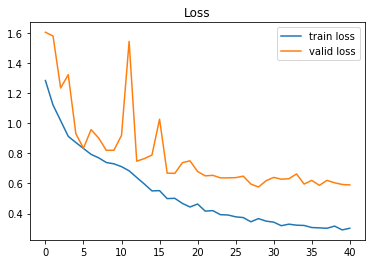

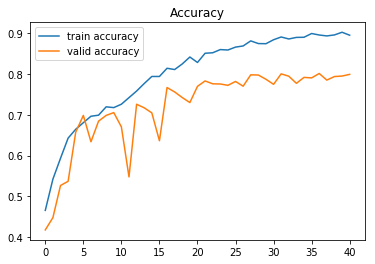

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
Plot results
"""
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [393]:
from winsound import Beep
Beep(2500, 1000)

## Prediction

In [9]:
from keras.preprocessing import image
import os

In [10]:
model = build_model(train, num_conv_layer = 3, num_layer_node = [1024, 512, 256, 128], num_filters=128)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.load_weights('checkpoint.h5')

In [12]:
cls_list = list(train.class_indices)

In [13]:
files = os.listdir(os.path.join(os.getcwd(), 'image_data', 'test'))
files[:5]

['0028624c49b3e0610ff9f1d111f5d532.jpg',
 '002c30700185b7971369258b438070d5.jpg',
 '00852f4f666acecd0c0d140365b42efd.jpg',
 '00c08828fce04e360c732cac01edad9e.jpg',
 '00d366e7877b6a78b104b57d67b60e6b.jpg']

In [14]:
cls_list

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

0.615419  tulip
0.211912  dandelion
0.122624  rose
0.026321  sunflower
0.023724  daisy


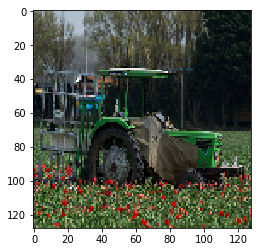

In [19]:
img = image.load_img(os.path.join(os.getcwd(), 'image_data', 'test', files[9]), target_size=TARGET_SIZE)
x = image.img_to_array(img)
x = x/255.
x = np.expand_dims(x, axis = 0)
x = validation_datagen.standardize(x)
pred = model.predict(x)[0]
plt.imshow(img)
top_inds = pred.argsort()[::-1][:5]
# result.loc[i] = [f[:-4], top_inds[0]]    
# print(f)

# if i >= 10:
#     break
# fig.add_subplot(10, 1, i+1)
# plt.imshow(img)

for i in top_inds:
    print('{:f}  {}'.format(pred[i], cls_list[i]))  
    

In [92]:
cls_list = list(train.class_indices.keys())
result = pd.DataFrame(columns=['id','flower_class'])
for i,f in enumerate(files):
    img = image.load_img(os.path.join(os.getcwd(), 'image_data', 'test', f), target_size=TARGET_SIZE)
    if img is None:
        continue
    x = image.img_to_array(img)
    x = x/255.
    x = np.expand_dims(x, axis = 0)
    x = validation_datagen.standardize(x)
    pred = model.predict(x)[0]
    top_inds = pred.argsort()[::-1][:5]
    result.loc[i] = [f[:-4], top_inds[0]]    
#     print(f)
#     for i in top_inds:
#         print('    {:.3f}  {}'.format(pred[i], cls_list[i]))

In [93]:
result.head()

,id,flower_class
0,0028624c49b3e0610ff9f1d111f5d532,2
1,002c30700185b7971369258b438070d5,4
2,00852f4f666acecd0c0d140365b42efd,2
3,00c08828fce04e360c732cac01edad9e,4
4,00d366e7877b6a78b104b57d67b60e6b,4


In [94]:
result.to_csv('checkpoint_regularizer.csv', index=False)